In [0]:
#Import modules
import numpy as np
import holidays
import pandas as pd
import seaborn as sns
import pickle
import time
import timeit


import matplotlib.pyplot as plt
plt.style.use('dark_background')
%matplotlib inline

import datetime
import math
from collections import Counter

#scipy
import scipy.stats as stats
from scipy import stats
from scipy.stats import chi2_contingency

#sklearn
import sklearn
from sklearn import ensemble
from sklearn import preprocessing
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, log_loss, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.utils import resample

#for clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

#other learners
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from kmodes.kmodes import KModes

#imblearn
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.ensemble import BalancedRandomForestClassifier


#time series
import statsmodels.api as sm
from pylab import rcParams
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA


In [0]:
#import pickled file
df = pd.read_pickle("df.pkl")

In [0]:
#import files

ac = pd.read_csv(r'Accident_Information.csv', low_memory=False, chunksize=30000)
vc = pd.read_csv(r'Vehicle_Information.csv', low_memory=False, chunksize=30000)

In [0]:
#chunk cleaning and dataframing for accident dataset
acchunk = []
for chunk in ac:
    acchunk_filter = chunk[
        (chunk.Year.astype(int) >= 2010) &
        (chunk.Year.astype(int) <= 2017) &
        (chunk['Road_Type'] != "Unknown") &
        (chunk['Junction_Control'] != "Data missing or out of range") &
        (chunk['Carriageway_Hazards'] != "Data missing or out of range") &
        (chunk['Junction_Detail'] != "Data missing or out of range") &
        (chunk['Road_Surface_Conditions'] != "Data missing or out of range") &
        (chunk['Special_Conditions_at_Site'] != "Data missing or out of range") &
        (chunk['Weather_Conditions'] != "Data missing or out of range") &
        (chunk['Latitude'].notnull()) &
        (chunk['Longitude'].notnull())
    ]
    acchunk.append(acchunk_filter)
df1 = pd.concat(acchunk)


In [0]:
#chunk cleaning for vehicles dataset
vcchunk = []
for chunk2 in vc:
    vcchunk_filter = chunk2[
        (chunk2.Year.astype(int) >= 2010)&
        (chunk2.Year.astype(int) <= 2017) &
        (chunk2['Driver_Home_Area_Type'] != "Data missing or out of range") &
        (chunk2['Journey_Purpose_of_Driver'] != "Data missing or out of range") &
        (chunk2['Junction_Location'] != "Data missing or out of range") &
        (chunk2['Was_Vehicle_Left_Hand_Drive'] != "Data missing or out of range") &
        (chunk2['Hit_Object_in_Carriageway'] != "Data missing or out of range") &
        (chunk2['Skidding_and_Overturning'] != "Data missing or out of range") &
        (chunk2['Towing_and_Articulation'] != "Data missing or out of range") &
        (chunk2['Vehicle_Leaving_Carriageway'] != "Data missing or out of range") &
        (chunk2['Vehicle_Manoeuvre'] != "Data missing or out of range") &
        (chunk2['Vehicle_Type'] != "Data missing or out of range") &
        (chunk2['X1st_Point_of_Impact'] != "Data missing or out of range") &
        (chunk2['Sex_of_Driver'] != "Data missing or out of range") &
        (chunk2['Age_Band_of_Driver'] != "Data missing or out of range")
        
    ]
    vcchunk.append(vcchunk_filter)
df2 = pd.concat(vcchunk)

In [0]:
#merging dataframes
df = pd.merge(df1,df2)

In [0]:
#after merging two dataframes
df.describe(include ='all')

,Accident_Index,1st_Road_Class,1st_Road_Number,2nd_Road_Class,2nd_Road_Number,Accident_Severity,Carriageway_Hazards,Date,Day_of_Week,Did_Police_Officer_Attend_Scene_of_Accident,...,Sex_of_Driver,Skidding_and_Overturning,Towing_and_Articulation,Vehicle_Leaving_Carriageway,Vehicle_Location.Restricted_Lane,Vehicle_Manoeuvre,Vehicle_Reference,Vehicle_Type,Was_Vehicle_Left_Hand_Drive,X1st_Point_of_Impact
count,720280,720280,720280.000000,699431,710979.000000,720280,720280,720280,720280,720279.000000,...,720280,720280,720280,720280,720269.000000,720280,720280.000000,720280,720280,720280
unique,488010,6,NaN,6,NaN,3,6,2557,7,NaN,...,3,6,6,9,NaN,18,NaN,20,2,5
top,2016140142191,A,NaN,Unclassified,NaN,Slight,None,2015-05-13,Friday,NaN,...,Male,None,No tow/articulation,Did not leave carriageway,NaN,Going ahead other,NaN,Car,No,Front
freq,15,365390,NaN,473098,NaN,626656,714068,515,119324,NaN,...,484205,659742,713570,663463,NaN,314008,NaN,534189,719140,354438
mean,NaN,NaN,1051.470728,NaN,607.761499,NaN,NaN,NaN,NaN,1.147353,...,NaN,NaN,NaN,NaN,0.086026,NaN,1.506420,NaN,NaN,NaN
std,NaN,NaN,1825.784600,NaN,1593.978070,NaN,NaN,NaN,NaN,0.357791,...,NaN,NaN,NaN,NaN,0.784117,NaN,0.644346,NaN,NaN,NaN
min,NaN,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,1.000000,...,NaN,NaN,NaN,NaN,0.000000,NaN,1.000000,NaN,NaN,NaN
25%,NaN,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,1.000000,...,NaN,NaN,NaN,NaN,0.000000,NaN,1.000000,NaN,NaN,NaN
50%,NaN,NaN,191.000000,NaN,0.000000,NaN,NaN,NaN,NaN,1.000000,...,NaN,NaN,NaN,NaN,0.000000,NaN,1.000000,NaN,NaN,NaN
75%,NaN,NaN,900.000000,NaN,173.000000,NaN,NaN,NaN,NaN,1.000000,...,NaN,NaN,NaN,NaN,0.000000,NaN,2.000000,NaN,NaN,NaN


In [0]:
#check corr b/t Location_Easting_OSGR & Location_Northing_OSGR AND Longitude and Latitude

print(df['Location_Easting_OSGR'].corr(df['Longitude']))


print(df['Location_Northing_OSGR'].corr(df['Latitude']))

0.999425701544617
0.9999733124707393


In [0]:
#since they are the similar to Latitude and Longitude 

df = df.drop(['Location_Easting_OSGR', 'Location_Northing_OSGR'], axis=1)

In [0]:
#standardize all column names to lowercase, and remove some characters 

df.columns = map(str.lower, df.columns)
df.columns = df.columns.str.replace('.','')
df.columns = df.columns.str.replace('(','')
df.columns = df.columns.str.replace(')','')

In [0]:
#converting date/time to datetime datatype

df['date'] = pd.to_datetime((df['date']), format= "%Y-%m-%d")



In [0]:
df.isnull().sum().sort_values(ascending=False)/df.shape[0]*100

driver_imd_decile                              25.118565
age_of_vehicle                                 15.287805
model                                          11.636447
engine_capacity_cc                             11.283251
propulsion_code                                10.899928
make                                            5.846476
lsoa_of_accident_location                       5.674738
2nd_road_class                                  2.894569
2nd_road_number                                 1.291303
pedestrian_crossing-physical_facilities         0.006109
pedestrian_crossing-human_control               0.005276
time                                            0.004582
speed_limit                                     0.001805
vehicle_locationrestricted_lane                 0.001527
did_police_officer_attend_scene_of_accident     0.000139
day_of_week                                     0.000000
1st_road_class                                  0.000000
number_of_vehicles             

In [0]:
# #number_of_casualties
df['number_of_casualties'].value_counts()

1     391938
2     113736
3      35451
4      12511
5       4621
6       1739
7        599
8        243
9        146
10        52
11        29
12        28
13        15
16        10
14         4
15         3
17         3
24         2
21         2
19         1
22         1
43         1
Name: number_of_casualties, dtype: int64

In [0]:
#create casualities grouping

def casualities(num_cas):
    if num_cas >=1 and num_cas <2:
        return "1"
    elif num_cas >=2 and num_cas <3:
        return "2"
    elif num_cas >=3 and num_cas <4:
        return "3"
    elif num_cas >= 4 and num_cas <5:
        return "4"
    elif num_cas >= 5:
        return "5+"
  
    

In [0]:
#apply function   
df['number_of_casualties']= df['number_of_casualties'].apply(casualities)

In [0]:
#number_of_casualties
df['number_of_casualties'].value_counts()

1     391938
2     113736
3      35451
4      12511
5+      7499
Name: number_of_casualties, dtype: int64

In [0]:
#create time_of_day grouping

def daygroup(hour):
    if hour >= 6 and hour < 10:
        return "1"
    elif hour >= 10 and hour < 12:
        return "2"
    elif hour >= 12 and hour < 14:
        return "3"
    elif hour >= 14 and hour < 16:
        return "4"
    elif hour >= 16 and hour < 18:
        return "5"
    elif hour >= 18 and hour < 22:
        return "6"
    else:
        return "7"
    

In [0]:
#apply function   
#time of day function
df['time_of_day']= df['hour'].apply(daygroup)   

In [0]:
df[['weekend','day_of_week','time', 'time_of_day']].tail(10)

,weekend,day_of_week,time,time_of_day
720270,0,Wednesday,08:45,1
720271,0,Wednesday,08:45,1
720272,0,Tuesday,18:12,6
720273,1,Sunday,11:00,2
720274,1,Sunday,11:00,2
720275,0,Monday,16:32,5
720276,0,Monday,16:32,5
720277,1,Friday,06:45,1
720278,0,Tuesday,16:45,5
720279,0,Tuesday,16:45,5


In [0]:
# number_of_vehicles
df['number_of_vehicles'].value_counts()/df.shape[0]*100

2     72.944835
3     11.924403
1     11.570121
4      2.706122
5      0.582747
6      0.167874
7      0.059166
8      0.021385
11     0.005881
9      0.005881
10     0.004277
14     0.002317
13     0.002139
16     0.001782
12     0.001069
Name: number_of_vehicles, dtype: float64

In [0]:
#group number_of_vehicles

def vehicles(num_veh):
    if num_veh >=1 and num_veh <2:
        return "1"
    elif num_veh >=2 and num_veh <3:
        return "2"
    elif num_veh >=3 and num_veh <4:
        return "3"
    elif num_veh >= 4: 
        return "4+"
  
#apply function   
df['number_of_vehicles']= df['number_of_vehicles'].apply(vehicles)

In [0]:
# number_of_vehicles
df['number_of_vehicles'].value_counts()/df.shape[0]*100

2     72.944835
3     11.924403
1     11.570121
4+     3.560640
Name: number_of_vehicles, dtype: float64

In [0]:
df['number_of_vehicles']=df['number_of_vehicles'].astype('object')

In [0]:
#creating seasons column for ML

#creating season column

def getSeason(month):
    if (month == 12 or month == 1 or month == 2):
       return "winter"
    elif(month == 3 or month == 4 or month == 5):
       return "spring"
    elif(month == 6 or month== 7 or month == 8):
       return "summer"
    else:
       return "fall"

df['season'] = df['month'].apply(getSeason)

In [0]:
# number_of_vehicles
df['season'].value_counts()/df.shape[0]*100

fall      27.065858
summer    25.502241
spring    24.624912
winter    22.806989
Name: season, dtype: float64

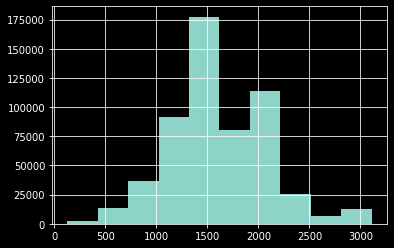

In [0]:
#go back to engine capacity CC and crete groups
df.engine_capacity_cc.hist()

In [0]:
def enginecap(eng_cc):
    if eng_cc <=1500:
        return "small engine cc"
    if eng_cc >1500 and eng_cc <=2000:
        return "medium engine cc"
    if eng_cc >2000:
        return "large engine cc"


df['engine_capacity_cc_size'] = df['engine_capacity_cc'].apply(enginecap)

In [0]:
df.engine_capacity_cc_size.value_counts()

medium engine cc    259881
small engine cc     231031
large engine cc      70223
Name: engine_capacity_cc_size, dtype: int64

In [0]:
#Put above pickle in next full run
#create new column for Machine Learning and Visualization with Not Serious and Serious
df['accident_seriousness'] = df['accident_severity']
df['accident_seriousness'] = df['accident_seriousness'].replace(to_replace="Slight", 
                                                                value="Not Serious")
df['accident_seriousness'] = df['accident_seriousness'].replace(to_replace="Serious",
                                                                value="Serious")
df['accident_seriousness'] = df['accident_seriousness'].replace(to_replace="Fatal", 
                                                                value="Serious")
df.shape

(561135, 60)

In [0]:
df.accident_seriousness.value_counts()

Not Serious    492804
Serious         68331
Name: accident_seriousness, dtype: int64

In [0]:
#pickling everything to speed up restarting
df.to_pickle("df.pkl")

In [0]:
#import pickled file
df = pd.read_pickle("df.pkl")
df.head()

,accident_index,1st_road_class,1st_road_number,2nd_road_number,accident_severity,carriageway_hazards,date,day_of_week,did_police_officer_attend_scene_of_accident,junction_control,...,vehicle_type,was_vehicle_left_hand_drive,x1st_point_of_impact,month,weekend,hour,time_of_day,season,engine_capacity_cc_size,accident_seriousness
0,201001BS70003,B,302,0,Slight,None,2010-01-11,Monday,1,Give way or uncontrolled,...,Goods Vehicle,No,Front,1,0,7,1,winter,small engine cc,Not Serious
1,201001BS70004,A,402,4204,Slight,None,2010-01-11,Monday,1,Auto traffic signal,...,Car,No,Front,1,0,18,6,winter,medium engine cc,Not Serious
3,201001BS70007,Unclassified,0,0,Slight,None,2010-01-02,Saturday,1,Give way or uncontrolled,...,Car,No,Nearside,1,1,21,6,winter,medium engine cc,Not Serious
4,201001BS70007,Unclassified,0,0,Slight,None,2010-01-02,Saturday,1,Give way or uncontrolled,...,Car,No,Front,1,1,21,6,winter,small engine cc,Not Serious
5,201001BS70008,A,3217,3220,Slight,None,2010-01-04,Monday,1,Auto traffic signal,...,Car,No,Nearside,1,0,20,6,winter,medium engine cc,Not Serious


Visualizations

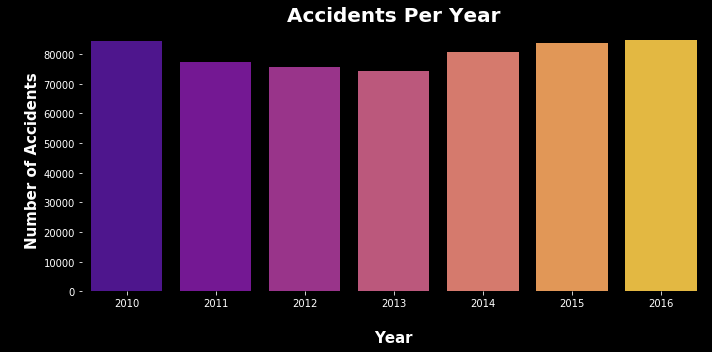

In [0]:
accidentsperyear = df.groupby(['year'])['accident_index'].count()

# prepare plot
plt.style.use('dark_background')
plt.figure(figsize=(10,5))
colors = sns.color_palette("plasma", n_colors=7)
sns.barplot(accidentsperyear.index,accidentsperyear.values, palette=colors)
sns.despine(top=True, right=True, left=True, bottom=True)
plt.title("Accidents Per Year",fontsize=20,fontweight="bold")
plt.xlabel("\nYear", fontsize=15, fontweight="bold")
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.savefig('accidentsperyear.png')
plt.tight_layout()


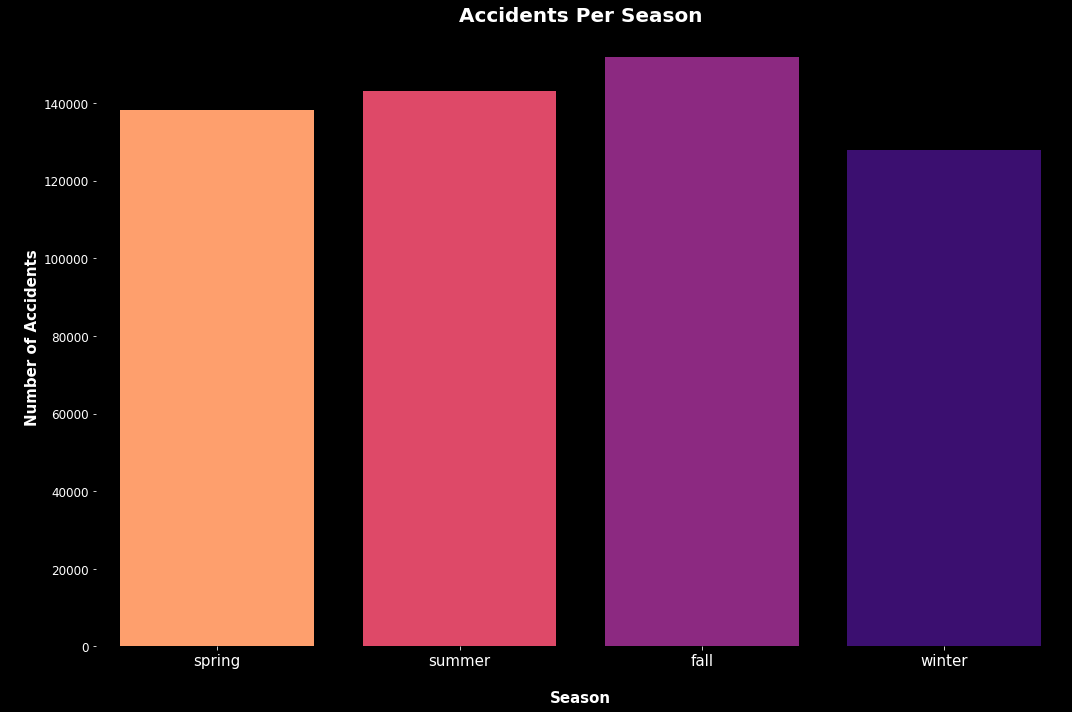

In [0]:
accidentsperseason = df.groupby(['season'])['accident_index'].count()
seaord=['spring', 'summer', 'fall','winter']
# prepare plot
plt.style.use('dark_background')
plt.figure(figsize=(15,10))

sns.barplot(accidentsperseason.index,accidentsperseason.values, order=seaord, 
            saturation=1, palette='magma_r')
sns.despine(top=True, right=True, left=True, bottom=True)
plt.title("Accidents Per Season",fontsize=20,fontweight="bold")
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.xlabel("\nSeason", fontsize=15, fontweight="bold")
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.tight_layout()
plt.savefig('accidentsperseason.png')


In [0]:
#"Morning Rush (6-10)", "Day (10-12)", "Lunch Rush (12-14)","Afternoon (14-16)",
#"After Work Rush (16-18)", "Evening (18-22)", "Night (22-6)"

timeofdaygroups = {'1': "Morning Rush",
                   '2': "Day",
                   '3': "Lunch Rush",
                   '4': "Afternoon",
                   '5': "After Work Rush",
                   '6': "Evening",
                   '7': "Night"}
df['time_of_day']=df['time_of_day'].map(timeofdaygroups)

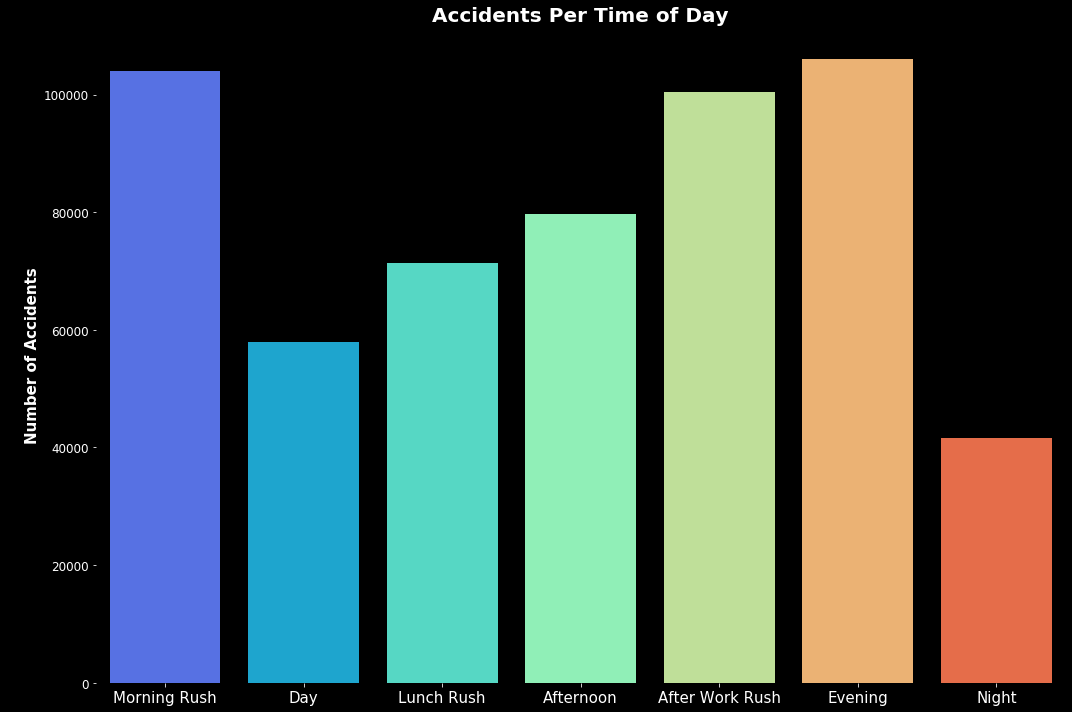

In [0]:
accidentspertod = df.groupby(['time_of_day'])['accident_index'].count()

# prepare plot
plt.style.use('dark_background')
plt.figure(figsize=(15,10))
tod=["Morning Rush", "Day", "Lunch Rush", "Afternoon",
     "After Work Rush", "Evening", "Night"]
sns.barplot(accidentspertod.index,accidentspertod.values, order=tod, palette='rainbow')
sns.despine(top=True, right=True, left=True, bottom=True)
plt.title("Accidents Per Time of Day",fontsize=20,fontweight="bold")
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)

plt.xlabel("", fontsize=15, fontweight="bold")
plt.ylabel("\nNumber of Accidents", fontsize=15, fontweight="bold")
plt.tight_layout()
plt.savefig('accidentspertod.png')


In [0]:
#correlation by accident severity pearson
corrdf=df.apply(LabelEncoder().fit_transform)
sc = StandardScaler()
corrdf = sc.fit_transform(corrdf)
corrdf=pd.DataFrame(data=corrdf,columns=df.columns)
corr=corrdf.corr()['accident_seriousness']
corr[np.argsort(corr,axis=0)[::-1]]

accident_seriousness                           1.000000
vehicle_type                                   0.133941
x1st_point_of_impact                           0.076099
speed_limit                                    0.065554
skidding_and_overturning                       0.059322
vehicle_leaving_carriageway                    0.058977
sex_of_driver                                  0.054505
lsoa_of_accident_location                      0.048548
number_of_casualties                           0.043294
age_band_of_driver                             0.039851
junction_control                               0.037966
hit_object_off_carriageway                     0.036040
time_of_day                                    0.026101
model                                          0.022808
accident_index                                 0.022391
junction_location                              0.019548
road_type                                      0.019443
engine_capacity_cc_size                        0

In [0]:
corr_spear=corrdf.corr(method='spearman')['accident_seriousness']
corr_spear[np.argsort(corr_spear,axis=0)[::-1]]

accident_seriousness                           1.000000
vehicle_type                                   0.114374
vehicle_leaving_carriageway                    0.071079
x1st_point_of_impact                           0.067697
speed_limit                                    0.062779
skidding_and_overturning                       0.059746
sex_of_driver                                  0.054629
lsoa_of_accident_location                      0.048538
junction_control                               0.041690
age_band_of_driver                             0.037758
hit_object_off_carriageway                     0.034738
road_type                                      0.028215
time_of_day                                    0.026387
junction_location                              0.024224
junction_detail                                0.024051
accident_index                                 0.022667
number_of_casualties                           0.022535
engine_capacity_cc_size                        0

In [0]:


    
class ChiSquare:
    def __init__(self, dataframe):
        self.df = dataframe
        self.p = None #P-Value
        self.chi2 = None #Chi Test Statistic
        self.dof = None
        
        self.dfObserved = None
        self.dfExpected = None
        
    def _print_chisquare_result(self, colX, alpha):
        result = ""
        if self.p<alpha:
            result="The column {0} is IMPORTANT for Prediction".format(colX)
        else:
            result="The column {0} is NOT an important predictor. (Discard {0} from model)".format(colX)

        print(result)
        
    def TestIndependence(self,colX,colY, alpha=0.05):
        X = self.df[colX].astype(str)
        Y = self.df[colY].astype(str)
        
        self.dfObserved = pd.crosstab(Y,X) 
        chi2, p, dof, expected = stats.chi2_contingency(self.dfObserved.values)
        self.p = p
        self.chi2 = chi2
        self.dof = dof 
        
        self.dfExpected = pd.DataFrame(expected, columns=self.dfObserved.columns, 
                                       index = self.dfObserved.index)
        
        self._print_chisquare_result(colX,alpha)

#Initialize ChiSquare Class
cT = ChiSquare(df)

#Feature Selection
testColumns = ['accident_index', '1st_road_class', '1st_road_number','2nd_road_number', 
               'carriageway_hazards', 'date', 'day_of_week', 
               'did_police_officer_attend_scene_of_accident','junction_control', 
               'junction_detail', 'latitude', 'light_conditions', 'local_authority_district',
               'local_authority_highway', 'longitude','lsoa_of_accident_location', 
               'number_of_casualties', 'number_of_vehicles', 'pedestrian_crossing-human_control',
               'pedestrian_crossing-physical_facilities', 'police_force','road_surface_conditions', 
               'road_type', 'special_conditions_at_site', 'speed_limit', 'time', 
               'urban_or_rural_area', 'weather_conditions', 'year', 'inscotland', 
               'age_band_of_driver', 'age_of_vehicle', 'driver_home_area_type', 
               'driver_imd_decile', 'engine_capacity_cc','hit_object_in_carriageway', 
               'hit_object_off_carriageway', 'journey_purpose_of_driver', 'junction_location', 
               'make', 'model','propulsion_code', 'sex_of_driver', 'skidding_and_overturning',
               'towing_and_articulation', 'vehicle_leaving_carriageway',
               'vehicle_locationrestricted_lane', 'vehicle_manoeuvre','vehicle_reference',
               'vehicle_type', 'was_vehicle_left_hand_drive', 'x1st_point_of_impact', 'month',
               'weekend', 'hour', 'time_of_day','season', 'engine_capacity_cc_size']
for var in testColumns:
    cT.TestIndependence(colX=var,colY="accident_seriousness" )  

The column accident_index is IMPORTANT for Prediction
The column 1st_road_class is IMPORTANT for Prediction
The column 1st_road_number is IMPORTANT for Prediction
The column 2nd_road_number is IMPORTANT for Prediction
The column carriageway_hazards is IMPORTANT for Prediction
The column date is IMPORTANT for Prediction
The column day_of_week is IMPORTANT for Prediction
The column did_police_officer_attend_scene_of_accident is IMPORTANT for Prediction
The column junction_control is IMPORTANT for Prediction
The column junction_detail is IMPORTANT for Prediction
The column latitude is IMPORTANT for Prediction
The column light_conditions is IMPORTANT for Prediction
The column local_authority_district is IMPORTANT for Prediction
The column local_authority_highway is IMPORTANT for Prediction
The column longitude is IMPORTANT for Prediction
The column lsoa_of_accident_location is IMPORTANT for Prediction
The column number_of_casualties is IMPORTANT for Prediction
The column number_of_vehicles

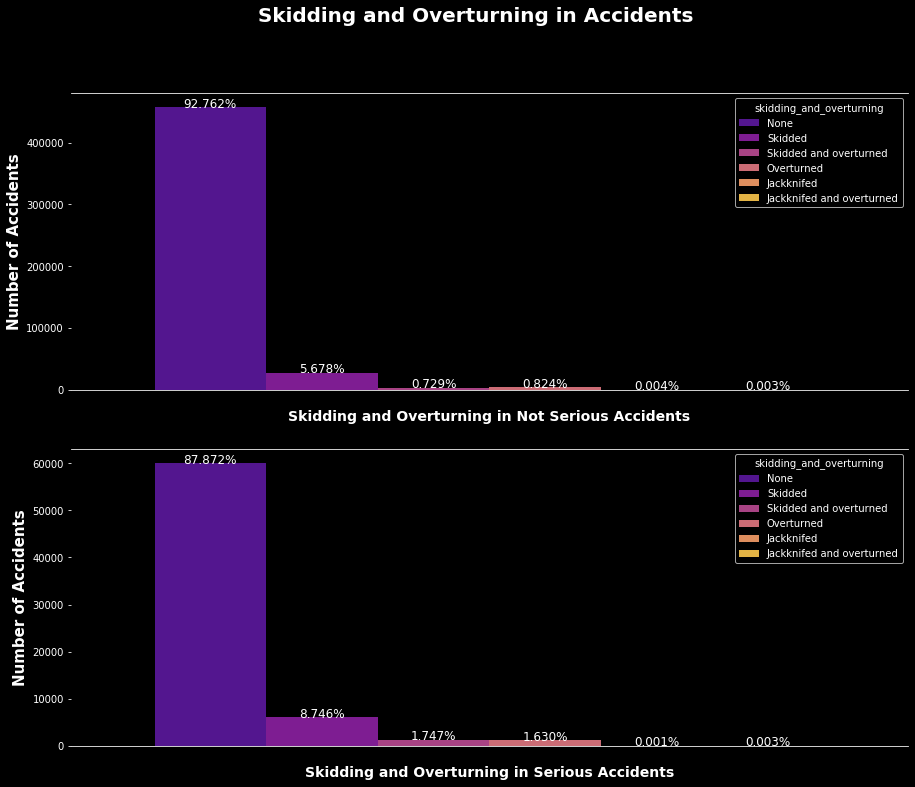

In [0]:
sao_order=["None", "Skidded", "Skidded and overturned", "Overturned", "Jackknifed", 
           "Jackknifed and overturned"]
fig, ax =plt.subplots(nrows=2, ncols=1,figsize = (15,12))
sns.despine(top=False, right=True, left=True)
ax1 =sns.countplot("accident_seriousness", hue="skidding_and_overturning", hue_order=sao_order,
              palette="plasma", data=not_serious, ax=ax[0])
for p in ax1.patches:
    height = p.get_height()
    ax1.text(p.get_x()+p.get_width()/2.,
            height + 4,
            '{:1.3f}%'.format(height/nstotal*100),
            ha="center",fontsize=12) 
ax2 =  sns.countplot("accident_seriousness", hue="skidding_and_overturning", hue_order=sao_order,
              palette="plasma", data=serious, ax=ax[1])
for p in ax2.patches:
    height = p.get_height()
    ax2.text(p.get_x()+p.get_width()/2.,
            height + 4,
            '{:1.3f}%'.format(height/setotal*100),
            ha="center",fontsize=12) 
fig.suptitle("Skidding and Overturning in Accidents", fontsize=20, fontweight="bold")
ax1.set_xlabel('\nSkidding and Overturning in Not Serious Accidents', fontsize=14, fontweight="bold")
ax2.set_xlabel('\nSkidding and Overturning in Serious Accidents', fontsize=14, fontweight="bold")
ax1.set_ylabel('Number of Accidents', fontsize=15, fontweight="bold")
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.set_ylabel('Number of Accidents', fontsize=15, fontweight="bold")
plt.style.use('dark_background')
plt.savefig('skidding_and_overturning.png')
fig.show()


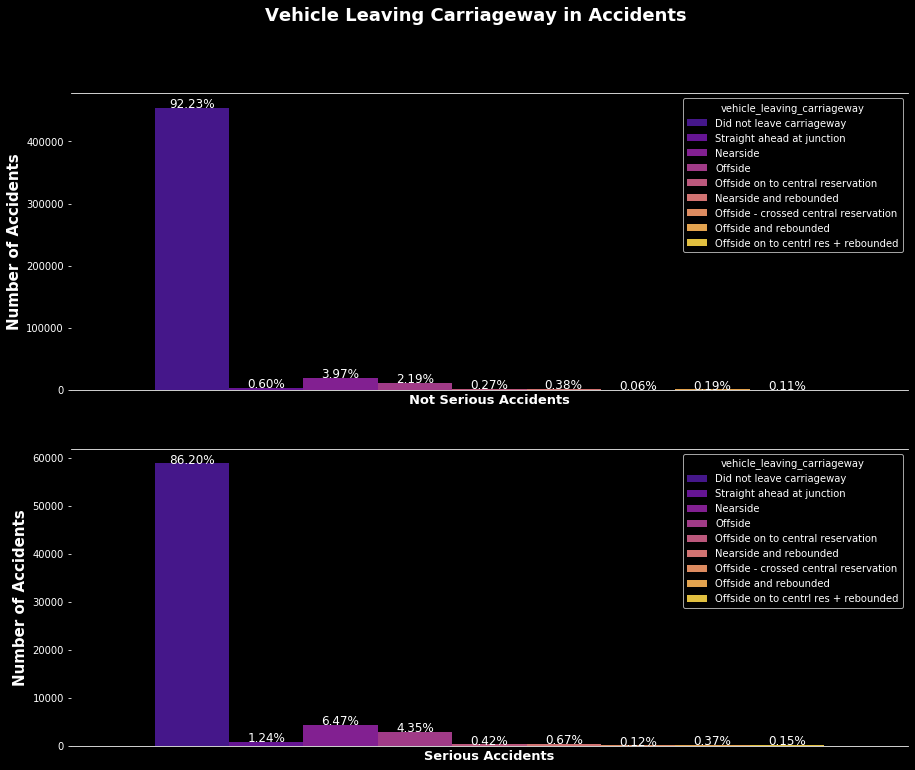

In [0]:
vlc_order=["Did not leave carriageway", "Straight ahead at junction", "Nearside", 
           "Offside", "Offside on to central reservation", "Nearside and rebounded", 
           "Offside - crossed central reservation", "Offside and rebounded", 
           "Offside on to centrl res + rebounded"]

fig, ax =plt.subplots(nrows=2, ncols=1,figsize = (15,12))
sns.despine(top=False, right=True, left=True)
ax1 =sns.countplot("accident_seriousness", hue="vehicle_leaving_carriageway", hue_order=vlc_order,
              palette="plasma", data=not_serious, ax=ax[0])
for p in ax1.patches:
    height = p.get_height()
    ax1.text(p.get_x()+p.get_width()/2.,
            height + 4,
            '{:1.2f}%'.format(height/nstotal*100),
            ha="center",fontsize=12) 
ax2 =  sns.countplot("accident_seriousness", hue="vehicle_leaving_carriageway", hue_order=vlc_order,
              palette="plasma", data=serious, ax=ax[1])
for p in ax2.patches:
    height = p.get_height()
    ax2.text(p.get_x()+p.get_width()/2.,
            height + 4,
            '{:1.2f}%'.format(height/setotal*100),
            ha="center",fontsize=12) 
fig.suptitle("Vehicle Leaving Carriageway in Accidents", fontsize=18, fontweight="bold")
ax1.set_xlabel('Not Serious Accidents\n\n', fontsize=13, fontweight="bold")
ax2.set_xlabel('Serious Accidents', fontsize=13, fontweight="bold")
ax1.set_ylabel('Number of Accidents', fontsize=15, fontweight="bold")
ax2.set_ylabel('Number of Accidents', fontsize=15, fontweight="bold")
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.style.use('dark_background')
plt.savefig('vehicle_leaving_carriageway.png')
fig.show()



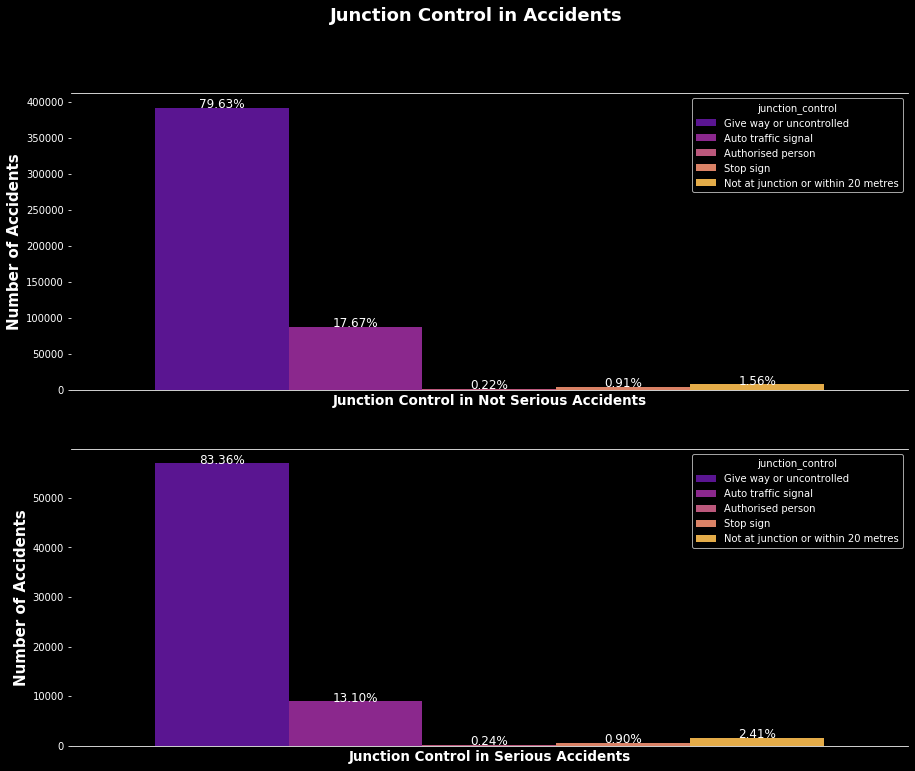

In [0]:
jc_order = ['Give way or uncontrolled', 'Auto traffic signal', 'Authorised person',
            'Stop sign','Not at junction or within 20 metres']

fig, ax =plt.subplots(nrows=2, ncols=1,figsize = (15,12))
sns.despine(top=False, right=True, left=True)

ax1 =sns.countplot("accident_seriousness", hue="junction_control", hue_order=jc_order,
              palette="plasma", data=not_serious, ax=ax[0])
for p in ax1.patches:
    height = p.get_height()
    ax1.text(p.get_x()+p.get_width()/2.,
            height + 4,
            '{:1.2f}%'.format(height/nstotal*100),
            ha="center",fontsize=12) 
    
ax2 =  sns.countplot("accident_seriousness", hue="junction_control", hue_order=jc_order,
              palette="plasma", data=serious, ax=ax[1])
for p in ax2.patches:
    height = p.get_height()
    ax2.text(p.get_x()+p.get_width()/2.,
            height + 4,
            '{:1.2f}%'.format(height/setotal*100),
            ha="center",fontsize=12)
    
fig.suptitle("Junction Control in Accidents", fontsize=18, fontweight="bold")
ax1.set_xlabel('Junction Control in Not Serious Accidents\n', fontsize=13.5, fontweight="bold")
ax2.set_xlabel('Junction Control in Serious Accidents', fontsize=13.5, fontweight="bold")
ax1.set_ylabel('Number of Accidents', fontsize=15, fontweight="bold")
ax2.set_ylabel('Number of Accidents', fontsize=15, fontweight="bold")
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.style.use('dark_background')
plt.savefig('junction_control.png')
fig.show()


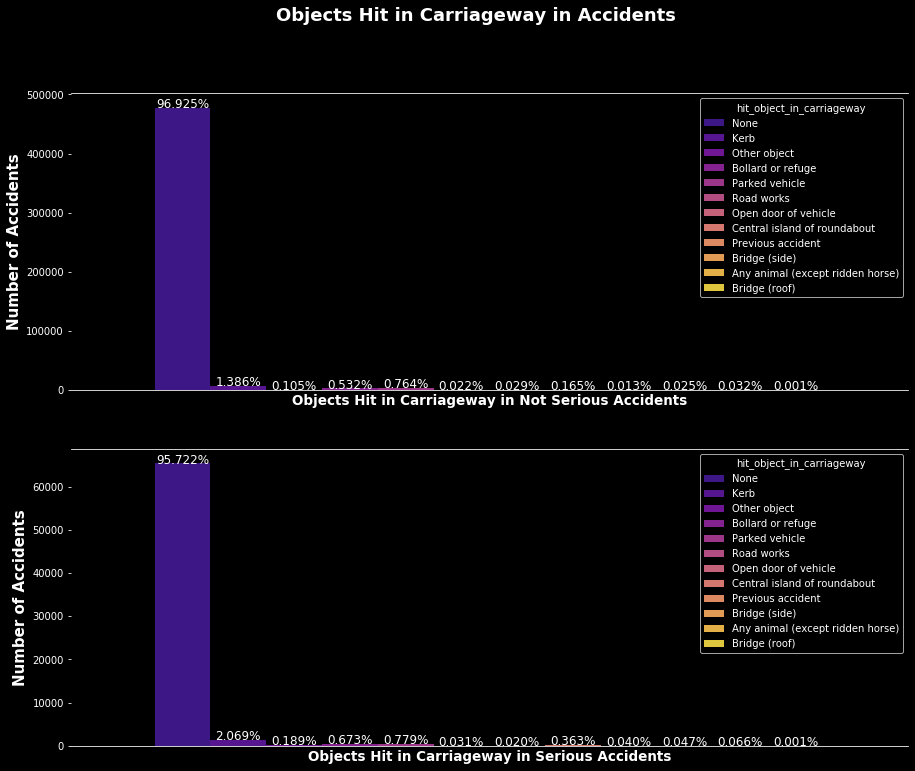

In [0]:
hoinc_order=['None', 'Kerb', 'Other object', 'Bollard or refuge', 'Parked vehicle',
             'Road works', 'Open door of vehicle', 'Central island of roundabout',
             'Previous accident', 'Bridge (side)', 'Any animal (except ridden horse)',
             'Bridge (roof)']


fig, ax =plt.subplots(nrows=2, ncols=1,figsize = (15,12))
sns.despine(top=False, right=True, left=True)

ax1 =sns.countplot("accident_seriousness", hue="hit_object_in_carriageway", hue_order=hoinc_order,
              palette="plasma", data=not_serious, ax=ax[0])
for p in ax1.patches:
    height = p.get_height()
    ax1.text(p.get_x()+p.get_width()/2.,
            height + 4,
            '{:1.3f}%'.format(height/nstotal*100),
            ha="center",fontsize=12) 
    
ax2 =  sns.countplot("accident_seriousness", hue="hit_object_in_carriageway", hue_order=hoinc_order,
              palette="plasma", data=serious, ax=ax[1])
for p in ax2.patches:
    height = p.get_height()
    ax2.text(p.get_x()+p.get_width()/2.,
            height + 4,
            '{:1.3f}%'.format(height/setotal*100),
            ha="center",fontsize=12)
    
fig.suptitle("Objects Hit in Carriageway in Accidents", fontsize=18, fontweight="bold")
ax1.set_xlabel('Objects Hit in Carriageway in Not Serious Accidents\n', fontsize=13.5, fontweight="bold")
ax2.set_xlabel('Objects Hit in Carriageway in Serious Accidents', fontsize=13.5, fontweight="bold")
ax1.set_ylabel('Number of Accidents', fontsize=15, fontweight="bold")
ax2.set_ylabel('Number of Accidents', fontsize=15, fontweight="bold")
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.style.use('dark_background')
plt.savefig('hit_object_in_carriageway.png')
fig.show()


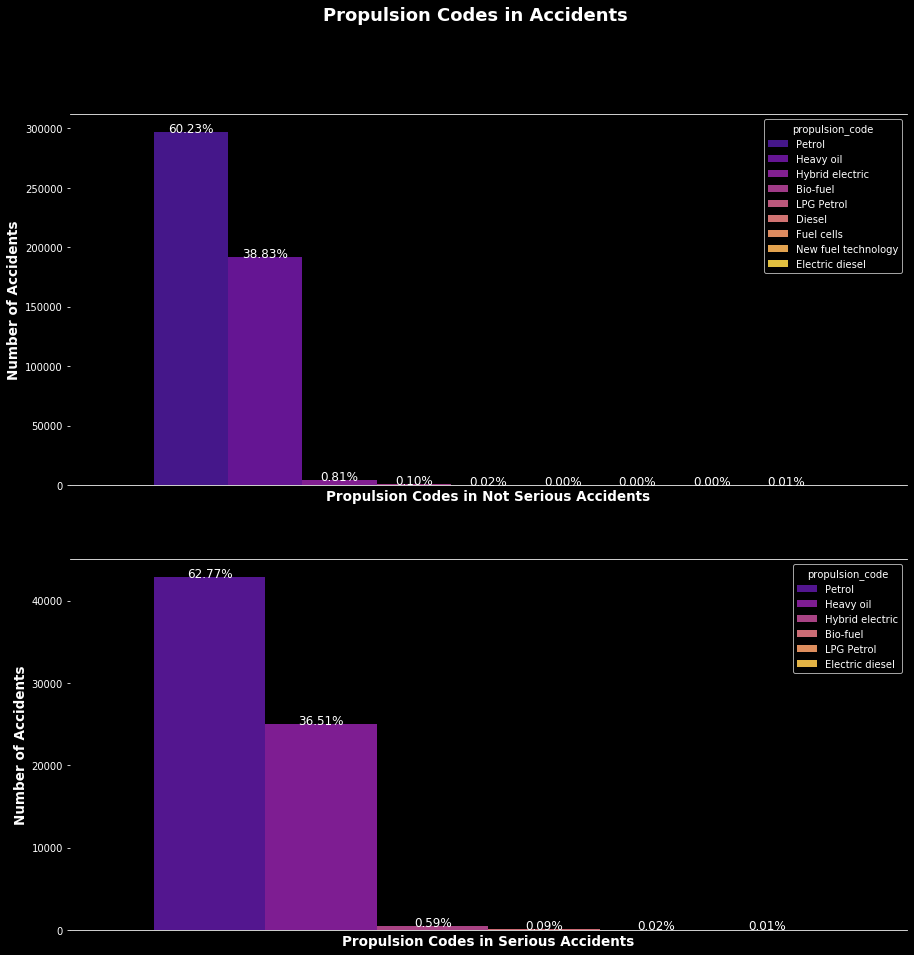

In [0]:
pd_order=['Petrol', 'Heavy oil', 'Hybrid electric', 'Bio-fuel', 'LPG Petrol', 'Diesel',
          'Fuel cells', 'New fuel technology', 'Electric diesel']
pd_order2=['Petrol', 'Heavy oil', 'Hybrid electric', 'Bio-fuel', 'LPG Petrol', 'Electric diesel']

fig, ax =plt.subplots(nrows=2, ncols=1,figsize = (15,15))
sns.despine(top=False, right=True, left=True)

ax1 =sns.countplot("accident_seriousness", hue="propulsion_code", hue_order=pd_order,
              palette="plasma", data=not_serious, ax=ax[0])
for p in ax1.patches:
    height = p.get_height()
    ax1.text(p.get_x()+p.get_width()/2.,
            height + 4,
            '{:1.2f}%'.format(height/nstotal*100),
            ha="center",fontsize=12) 
    
ax2 =  sns.countplot("accident_seriousness", hue="propulsion_code", hue_order=pd_order2,
              palette="plasma", data=serious, ax=ax[1])
for p in ax2.patches:
    height = p.get_height()
    ax2.text(p.get_x()+p.get_width()/2.,
            height + 4,
            '{:1.2f}%'.format(height/setotal*100),
            ha="center",fontsize=12)
    
fig.suptitle("Propulsion Codes in Accidents", fontsize=18, fontweight="bold")
ax1.set_xlabel('Propulsion Codes in Not Serious Accidents\n', fontsize=13.5, fontweight="bold")
ax2.set_xlabel('Propulsion Codes in Serious Accidents', fontsize=13.5, fontweight="bold")
ax1.set_ylabel('Number of Accidents', fontsize=13.5, fontweight="bold")
ax2.set_ylabel('Number of Accidents', fontsize=13.5, fontweight="bold")
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.style.use('dark_background')
plt.savefig('propulsion_code.png')
fig.show()


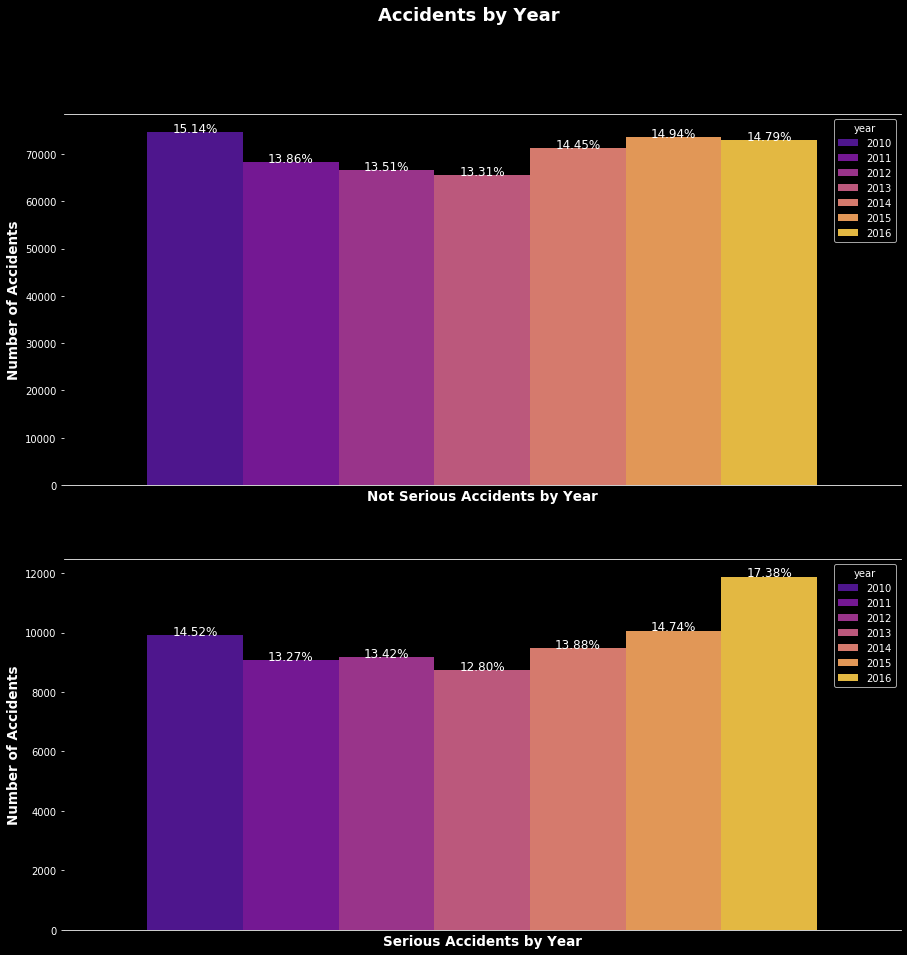

In [0]:
year_order=[2010, 2011, 2012, 2013, 2014, 2015, 2016]


fig, ax =plt.subplots(nrows=2, ncols=1,figsize = (15,15))
sns.despine(top=False, right=True, left=True)

ax1 =sns.countplot("accident_seriousness", hue="year", hue_order=year_order,
              palette="plasma", data=not_serious, ax=ax[0])
for p in ax1.patches:
    height = p.get_height()
    ax1.text(p.get_x()+p.get_width()/2.,
            height + 4,
            '{:1.2f}%'.format(height/nstotal*100),
            ha="center",fontsize=12) 
    
ax2 =  sns.countplot("accident_seriousness", hue="year", hue_order=year_order,
              palette="plasma", data=serious, ax=ax[1])
for p in ax2.patches:
    height = p.get_height()
    ax2.text(p.get_x()+p.get_width()/2.,
            height + 4,
            '{:1.2f}%'.format(height/setotal*100),
            ha="center",fontsize=12)
    
fig.suptitle("Accidents by Year", fontsize=18, fontweight="bold")
ax1.set_xlabel('Not Serious Accidents by Year\n', fontsize=13.5, fontweight="bold")
ax2.set_xlabel('Serious Accidents by Year', fontsize=13.5, fontweight="bold")
ax1.set_ylabel('Number of Accidents', fontsize=13.5, fontweight="bold")
ax2.set_ylabel('Number of Accidents', fontsize=13.5, fontweight="bold")
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.style.use('dark_background')
plt.savefig('year.png')
fig.show()


In [0]:
#using machine learning 
df1=df
#set index to accident_index
df1.set_index('accident_index', inplace=True)
df1.head()

In [0]:
df1 = df1.drop(['accident_severity'],axis=1)

In [0]:
df1.head()

,1st_road_class,1st_road_number,2nd_road_number,carriageway_hazards,date,day_of_week,did_police_officer_attend_scene_of_accident,junction_control,junction_detail,latitude,...,vehicle_type,was_vehicle_left_hand_drive,x1st_point_of_impact,month,weekend,hour,time_of_day,season,engine_capacity_cc_size,accident_seriousness
accident_index,,,,,,,,,,,,,,,,,,,,,
201001BS70003,B,302,0,None,2010-01-11,Monday,1,Give way or uncontrolled,T or staggered junction,51.484087,...,Goods Vehicle,No,Front,1,0,7,1,winter,small engine cc,Not Serious
201001BS70004,A,402,4204,None,2010-01-11,Monday,1,Auto traffic signal,T or staggered junction,51.509212,...,Car,No,Front,1,0,18,6,winter,medium engine cc,Not Serious
201001BS70007,Unclassified,0,0,None,2010-01-02,Saturday,1,Give way or uncontrolled,Mini-roundabout,51.513314,...,Car,No,Nearside,1,1,21,6,winter,medium engine cc,Not Serious
201001BS70007,Unclassified,0,0,None,2010-01-02,Saturday,1,Give way or uncontrolled,Mini-roundabout,51.513314,...,Car,No,Front,1,1,21,6,winter,small engine cc,Not Serious
201001BS70008,A,3217,3220,None,2010-01-04,Monday,1,Auto traffic signal,Crossroads,51.484361,...,Car,No,Nearside,1,0,20,6,winter,medium engine cc,Not Serious


In [0]:
#separate dtypes
notif=df1.select_dtypes(exclude=['int','float','int64'])
intfldtypes = df1.select_dtypes(include=['int','float','int64'])
print('Objects',notif.columns)
print("\nNonObjects",intfldtypes.columns)

#checking to make sure all are accounted for
print(df1.shape)
print(notif.shape)
print(intfldtypes.shape)

Objects Index(['1st_road_class', '1st_road_number', '2nd_road_number',
       'carriageway_hazards', 'date', 'day_of_week',
       'did_police_officer_attend_scene_of_accident', 'junction_control',
       'junction_detail', 'light_conditions', 'local_authority_district',
       'local_authority_highway', 'lsoa_of_accident_location',
       'number_of_casualties', 'number_of_vehicles',
       'pedestrian_crossing-human_control',
       'pedestrian_crossing-physical_facilities', 'police_force',
       'road_surface_conditions', 'road_type', 'special_conditions_at_site',
       'time', 'urban_or_rural_area', 'weather_conditions', 'inscotland',
       'age_band_of_driver', 'age_of_vehicle', 'driver_home_area_type',
       'hit_object_in_carriageway', 'hit_object_off_carriageway',
       'journey_purpose_of_driver', 'junction_location', 'make', 'model',
       'propulsion_code', 'sex_of_driver', 'skidding_and_overturning',
       'towing_and_articulation', 'vehicle_leaving_carriageway',
   

In [0]:
#label encode objects
obj_le= notif.apply(LabelEncoder().fit_transform)
#re-add with non-objects
df_ml= pd.concat([obj_le,intfldtypes], axis=1, sort=False)
#check shape
print(df_ml.shape)

(561135, 58)


In [0]:
#Set up of X and Y
X= df_ml.drop(['accident_seriousness'],axis=1)
y= df_ml['accident_seriousness']

In [0]:
df_ml.accident_seriousness.value_counts()

0    492804
1     68331
Name: accident_seriousness, dtype: int64

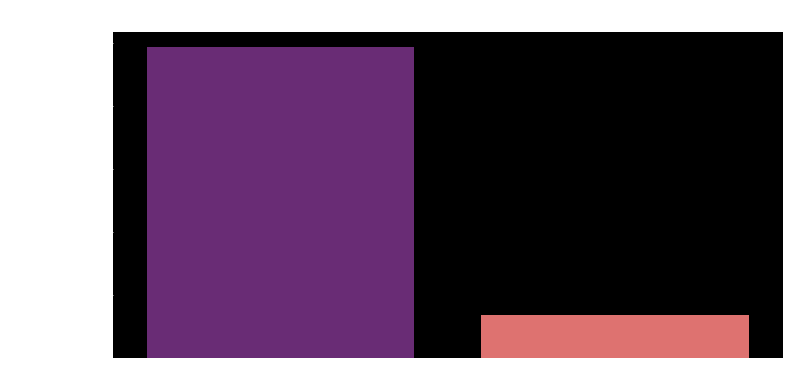

In [0]:
plt.figure(figsize=(12,6))
ax=sns.countplot(x="accident_seriousness", palette="magma", data=df)

plt.style.use('dark_background')
plt.title("Accident Seriousness",fontsize=25,fontweight="bold")
plt.xlabel("", fontsize=15, fontweight="bold")
plt.ylabel("\nNumber of Accidents\n", fontsize=15, fontweight="bold")
plt.xticks(fontsize=18)
plt.yticks(fontsize=12)
sns.despine(top=True, right=True, left=True, bottom=False)
plt.savefig('accident_seriousness.png')
plt.show()

In [0]:
# setting up testing and training sets
res_X_train, res_X_test, res_y_train, res_y_test = train_test_split(X, y, 
                                                                    test_size=0.25, random_state=27)

In [0]:
# concatenate our training data back together
res_X = pd.concat([res_X_train, res_y_train], axis=1)

In [0]:
# separate minority and majority classes
not_severe = res_X[res_X.accident_seriousness==0]
severe = res_X[res_X.accident_seriousness==1]

In [0]:
# decrease majority
not_severe_decreased = resample(not_severe,
                          replace=True, # sample with replacement
                          n_samples=len(severe), # match number in majority class
                          random_state=27) # reproducible results

In [0]:
# combine majority and severe_increased minority
newdf = pd.concat([severe, not_severe_decreased])

In [0]:
res_X_train = newdf.drop('accident_seriousness', axis=1)
res_y_train = newdf.accident_seriousness

In [0]:
# "clustering" using kmode algorithm that is designed to handle mixed data
km_huang = KModes(n_clusters=2, init = "Huang", n_init = 1)
fitClusters_huang = km_huang.fit_predict(newdf)
fitClusters_huang

array([1, 0, 0, ..., 0, 1, 1], dtype=uint16)

In [0]:
newdf1 = newdf.copy().reset_index()
clustersDf = pd.DataFrame(fitClusters_huang)
clustersDf.columns = ['cluster_predicted']
combinedDf = pd.concat([newdf1, clustersDf], axis = 1).reset_index()
combinedDf = combinedDf.drop(['index'], axis = 1)

In [0]:
combinedDf.head()

,accident_index,1st_road_class,1st_road_number,2nd_road_number,carriageway_hazards,date,day_of_week,did_police_officer_attend_scene_of_accident,junction_control,junction_detail,...,engine_capacity_cc_size,latitude,longitude,speed_limit,year,driver_imd_decile,engine_capacity_cc,month,accident_seriousness,cluster_predicted
0,201554A415715,0,429,0,1,2148,4,0,2,8,...,2,51.556002,-2.110741,30.0,2015,8.0,1299.0,11,1,1
1,2010440174154,0,27,2391,1,119,0,0,2,6,...,1,50.895352,-1.319297,30.0,2010,5.0,1997.0,4,1,0
2,201506N097860,5,0,0,1,1880,5,0,2,8,...,0,53.591164,-2.295013,30.0,2015,8.0,2143.0,2,1,0
3,2016460101917,0,252,251,1,2426,5,0,2,6,...,1,51.221226,0.878850,40.0,2016,8.0,1560.0,8,1,0
4,201342I085803,0,120,0,1,1182,4,0,2,8,...,2,51.877039,0.674514,60.0,2013,9.0,1149.0,3,1,0


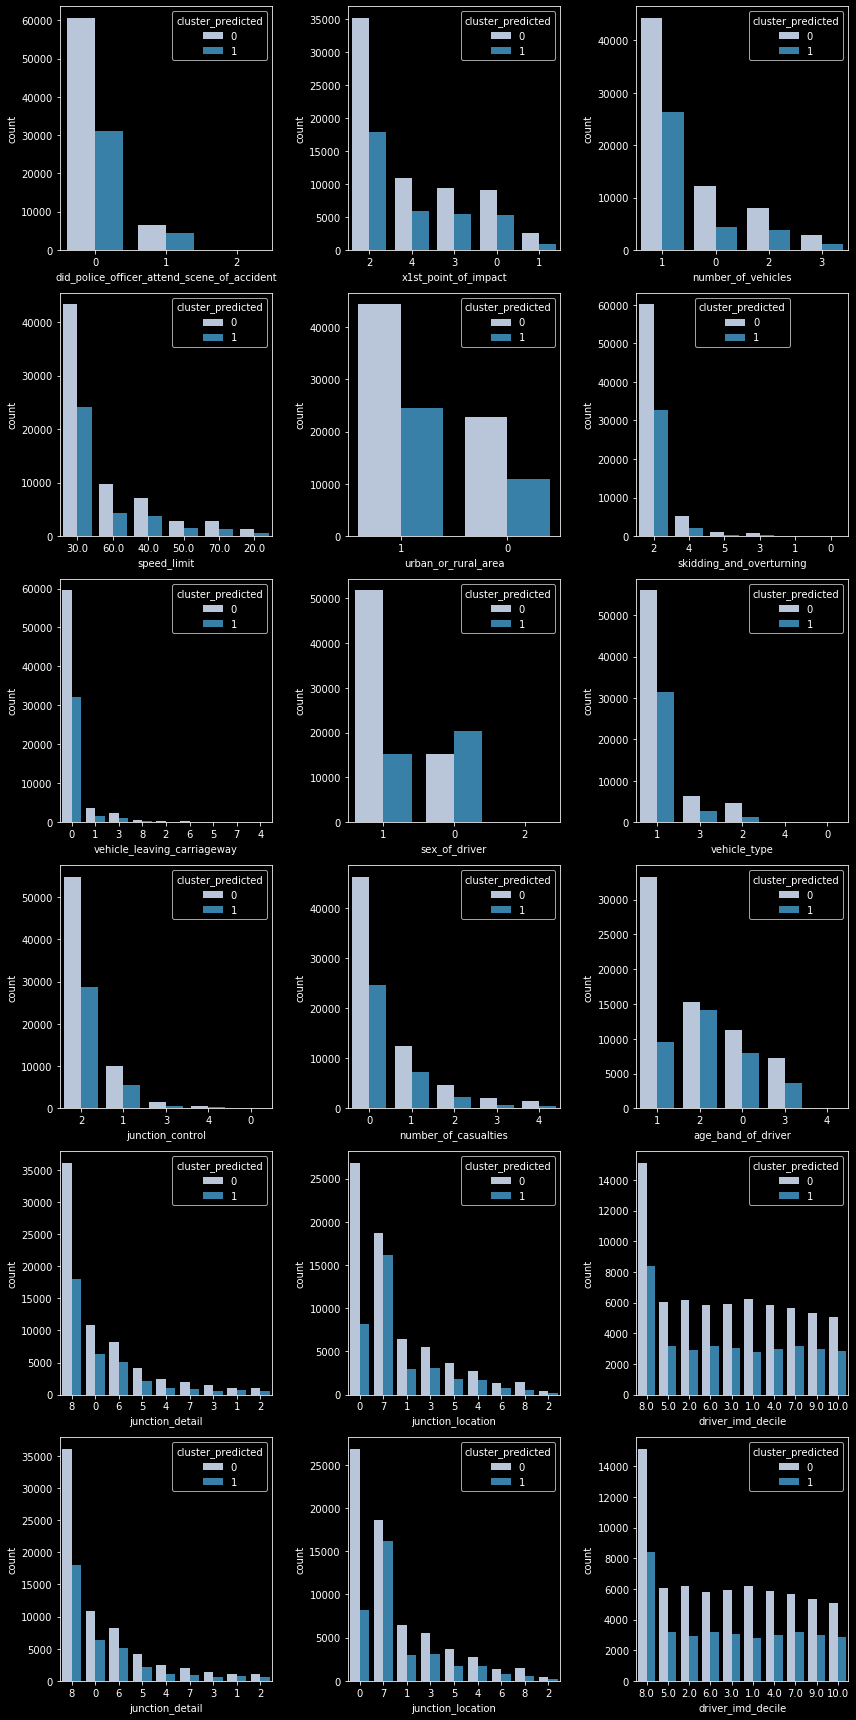

In [0]:
#plotting a few of these features just to see how they relate to the clustering for seriousness
f, axs = plt.subplots(nrows=6, ncols=3,figsize = (12,24))
plt.style.use('dark_background')
sns.countplot(x=combinedDf['did_police_officer_attend_scene_of_accident'],
              order=combinedDf['did_police_officer_attend_scene_of_accident'].value_counts().index,
              hue=combinedDf['cluster_predicted'], palette='PuBu', ax=axs[0,0])
sns.countplot(x=combinedDf['x1st_point_of_impact'],
              order=combinedDf['x1st_point_of_impact'].value_counts().index,
              hue=combinedDf['cluster_predicted'], palette='PuBu', ax=axs[0,1])
sns.countplot(x=combinedDf['number_of_vehicles'],
              order=combinedDf['number_of_vehicles'].value_counts().index,
              hue=combinedDf['cluster_predicted'], palette='PuBu', ax=axs[0,2])
sns.countplot(x=combinedDf['speed_limit'],
              order=combinedDf['speed_limit'].value_counts().index,
              hue=combinedDf['cluster_predicted'], palette='PuBu', ax=axs[1,0])
sns.countplot(x=combinedDf['urban_or_rural_area'],
              order=combinedDf['urban_or_rural_area'].value_counts().index,
              hue=combinedDf['cluster_predicted'], palette='PuBu', ax=axs[1,1])
sns.countplot(x=combinedDf['skidding_and_overturning'],
              order=combinedDf['skidding_and_overturning'].value_counts().index,
              hue=combinedDf['cluster_predicted'], palette='PuBu', ax=axs[1,2])
sns.countplot(x=combinedDf['vehicle_leaving_carriageway'],
              order=combinedDf['vehicle_leaving_carriageway'].value_counts().index,
              hue=combinedDf['cluster_predicted'], palette='PuBu', ax=axs[2,0])
sns.countplot(x=combinedDf['sex_of_driver'],
              order=combinedDf['sex_of_driver'].value_counts().index,
              hue=combinedDf['cluster_predicted'], palette='PuBu', ax=axs[2,1])
sns.countplot(x=combinedDf['vehicle_type'],
              order=combinedDf['vehicle_type'].value_counts().index,
              hue=combinedDf['cluster_predicted'], palette='PuBu', ax=axs[2,2])
sns.countplot(x=combinedDf['junction_control'],
              order=combinedDf['junction_control'].value_counts().index,
              hue=combinedDf['cluster_predicted'], palette='PuBu', ax=axs[3,0])
sns.countplot(x=combinedDf['number_of_casualties'],
              order=combinedDf['number_of_casualties'].value_counts().index,
              hue=combinedDf['cluster_predicted'], palette='PuBu', ax=axs[3,1])
sns.countplot(x=combinedDf['age_band_of_driver'],
              order=combinedDf['age_band_of_driver'].value_counts().index,
              hue=combinedDf['cluster_predicted'], palette='PuBu', ax=axs[3,2])
sns.countplot(x=combinedDf['junction_detail'],
              order=combinedDf['junction_detail'].value_counts().index,
              hue=combinedDf['cluster_predicted'], palette='PuBu', ax=axs[4,0])
sns.countplot(x=combinedDf['junction_location'],
              order=combinedDf['junction_location'].value_counts().index,
              hue=combinedDf['cluster_predicted'], palette='PuBu', ax=axs[4,1])
sns.countplot(x=combinedDf['driver_imd_decile'],
              order=combinedDf['driver_imd_decile'].value_counts().index,
              hue=combinedDf['cluster_predicted'], palette='PuBu', ax=axs[4,2])
sns.countplot(x=combinedDf['junction_detail'],
              order=combinedDf['junction_detail'].value_counts().index,
              hue=combinedDf['cluster_predicted'], palette='PuBu', ax=axs[5,0])
sns.countplot(x=combinedDf['junction_location'],
              order=combinedDf['junction_location'].value_counts().index,
              hue=combinedDf['cluster_predicted'], palette='PuBu', ax=axs[5,1])
sns.countplot(x=combinedDf['driver_imd_decile'],
              order=combinedDf['driver_imd_decile'].value_counts().index,
              hue=combinedDf['cluster_predicted'], palette='PuBu', ax=axs[5,2])
plt.tight_layout()
plt.savefig('clusterplot.png')
plt.show()

In [0]:
#confusion matrix plot function
def cm_plot(var):
    plt.figure(figsize=(15,5))
    plt.style.use('dark_background')
    plt.clf()
    plt.imshow(var, interpolation='nearest', cmap='tab20')
    classNames = ['Not Serious','Serious']
    plt.title('Confusion Matrix')
    plt.ylabel('Actual\n')
    plt.xlabel('Predicted\n')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+"="+str(var[i][j]),horizontalalignment='center', 
                     color='black')
    plt.show()





BaggingClassifier Results:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 66.9727%
Cross validation scores: 0.6871312576669197
Log Loss: 0.6157355650730744


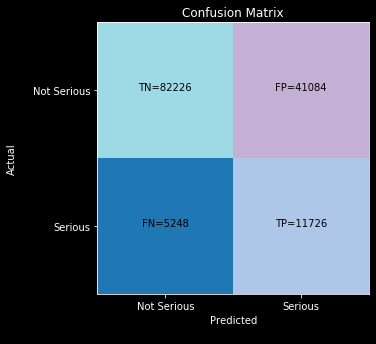





AdaBoostClassifier Results:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 66.7446%
Cross validation scores: 0.6572911190295384
Log Loss: 0.6880453803827911


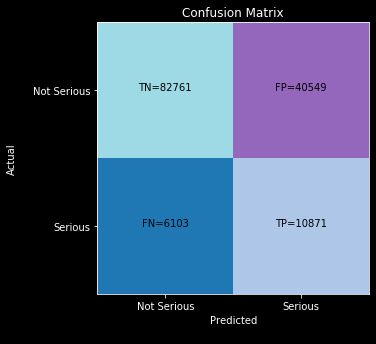





RandomForestClassifier Results:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 67.0882%
Cross validation scores: 0.6884942656307805
Log Loss: 0.6123101302134623


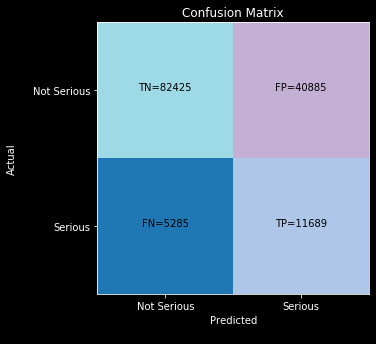





LGBMClassifier Results:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 67.8124%
Cross validation scores: 0.6796833927215374
Log Loss: 0.596513578691033


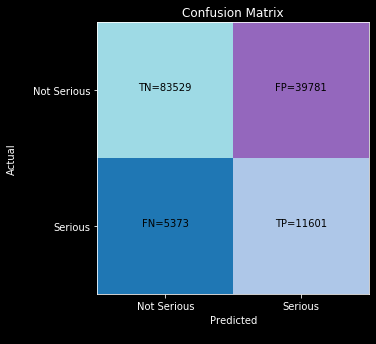





XGBClassifier Results:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 66.7995%
Cross validation scores: 0.6879295909028954
Log Loss: 0.6577360727445484


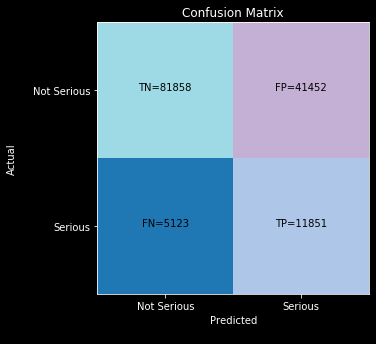

****************************************


In [0]:
#modeled using  different classification models
classifiers = [
    BaggingClassifier(max_features=X.shape[1], n_estimators=500, random_state=42),
    AdaBoostClassifier( n_estimators=500, learning_rate=0.05, random_state=42),
    RandomForestClassifier(criterion='entropy', max_depth=40,max_features=X.shape[1], 
                           min_samples_split=8, n_estimators=500, random_state=42),
    LGBMClassifier(learning_rate =0.03, max_depth=40, min_data_in_leaf=10,
                   n_estimators=500, num_leaves=50, random_state = 42),
    XGBClassifier(learning_rate=0.05, n_estimators=500, subsample= 1,random_state = 42,
                        gamma = 1, max_depth=40)]
    
    


#putting results in df
res_cols=["Classifier", "Accuracy", "Log Loss", "Cross Val", "Recall", "Roc Auc","F1", 
          "False Positive Rate", "Error Rate"]
results = pd.DataFrame(columns=res_cols)

for clf in classifiers:
    clf.fit(res_X_train, res_y_train)
    name = clf.__class__.__name__
    
    print("\n"*3)
    print(name,"Results:")
       
    print('~'*40)
    y_pred = clf.predict(res_X_test)
    acc = accuracy_score(res_y_test, y_pred)
    print("Accuracy: {:.4%}".format(acc))
    
    cv= np.mean(cross_val_score(clf, res_X_train, res_y_train, cv=3))
    print("Cross validation scores:",cv)
    
    
    train_predictions = clf.predict_proba(res_X_test)
    logloss = log_loss(res_y_test, train_predictions)
    print("Log Loss: {}".format(logloss))
    
    cm = confusion_matrix(res_y_test, y_pred)
    
    cm_plot(cm)
    
    #FPR and Error Rate setup
    tn, fp, fn, tp = confusion_matrix(res_y_test,y_pred).ravel()
    
    fpr = fp/(tn+fp)
    ers = 1-acc
    rec= recall_score(res_y_test, y_pred)
    roc=roc_auc_score(res_y_test, y_pred)
    f1s=f1_score(res_y_test, y_pred)
    results_final = pd.DataFrame([[name, round(acc*100,3), round(logloss,3), 
                                   round(cv*100,3), round(rec*100,3), round(roc*100,3),
                                   round(f1s*100,3),round(fpr*100,3),round(ers*100,3)]],
                                 columns=res_cols)
    results = results.append(results_final)
    
print("*"*40)

In [0]:
print("Results Shape",results.shape)
results.head(10)

Results Shape (5, 9)


,Classifier,Accuracy,Log Loss,Cross Val,Recall,Roc Auc,F1,False Positive Rate,Error Rate
0,BaggingClassifier,66.973,0.616,68.713,69.082,67.882,33.607,33.318,33.027
0,AdaBoostClassifier,66.745,0.688,65.729,64.045,65.581,31.789,32.884,33.255
0,RandomForestClassifier,67.088,0.612,68.849,68.864,67.854,33.614,33.156,32.912
0,LGBMClassifier,67.812,0.597,67.968,68.346,68.042,33.943,32.261,32.188
0,XGBClassifier,66.799,0.658,68.793,69.819,68.101,33.727,33.616,33.201


In [0]:
#train_tes_split without resampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)





BalancedBaggingClassifier Results:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 78.5321%
Cross validation scores: 0.7835718595519356
Log Loss: 0.5083639622989169


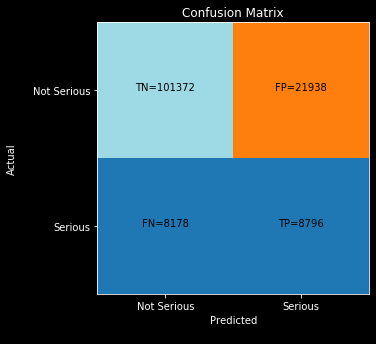





EasyEnsembleClassifier Results:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 66.6092%
Cross validation scores: 0.6677565267506275
Log Loss: 0.6897912318334272


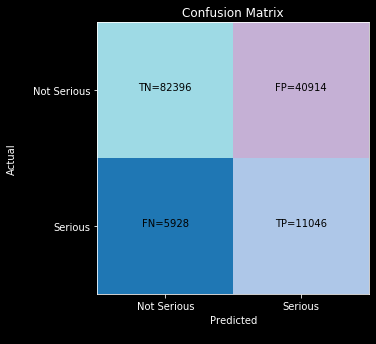





BalancedRandomForestClassifier Results:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 67.2785%
Cross validation scores: 0.6711282603625109
Log Loss: 0.6076769094064609


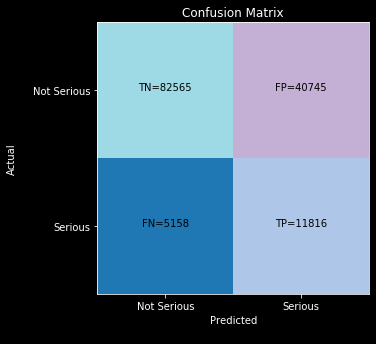

****************************************


In [0]:
#Try modeling using  different classification models
classifiers2 = [
    BalancedBaggingClassifier(max_features=X.shape[1], n_estimators=500, replacement=True,
                              sampling_strategy='majority', random_state=42),
    EasyEnsembleClassifier(n_estimators=500, random_state=42, replacement=True,
                           sampling_strategy='majority'),
    BalancedRandomForestClassifier(criterion='entropy', max_depth=40,min_samples_leaf = 1, 
                                   max_features=X.shape[1], sampling_strategy='majority', 
                                   replacement=True, min_samples_split=8, n_estimators=500,
                                   random_state=42)]

#putting results in df
res_cols2=["Classifier", "Accuracy", "Log Loss", "Cross Val", "Recall", "Roc Auc","F1", 
          "False Positive Rate", "Error Rate"]
results2 = pd.DataFrame(columns=res_cols2)

for clf2 in classifiers2:
    clf2.fit(X_train, y_train)
    name2 = clf2.__class__.__name__
    
    print("\n"*3)
    print(name2,"Results:")
       
    print('~'*40)
    y_pred2 = clf2.predict(X_test)
    acc2 = accuracy_score(y_test, y_pred2)
    print("Accuracy: {:.4%}".format(acc2))
    
    cv2= np.mean(cross_val_score(clf2, X_train, y_train, cv=3))
    print("Cross validation scores:",cv2)
    
    
    train_predictions2 = clf2.predict_proba(X_test)
    logloss2 = log_loss(y_test, train_predictions2)
    print("Log Loss: {}".format(logloss2))
    
    cm2 = confusion_matrix(y_test, y_pred2)
    
    cm_plot(cm2)
    
    #FPR and Error Rate setup
    tn, fp, fn, tp = confusion_matrix(y_test,y_pred2).ravel()
    
    fpr2 = fp/(tn+fp)
    ers2 = 1-acc
    rec2= recall_score(y_test, y_pred2)
    roc2=roc_auc_score(y_test, y_pred2)
    f1s2=f1_score(y_test, y_pred2)
    results_final2 = pd.DataFrame([[name2, round(acc2*100,3), round(logloss2,3), 
                                   round(cv2*100,3), round(rec2*100,3), round(roc2*100,3),
                                   round(f1s2*100,3),round(fpr2*100,3),round(ers2*100,3)]],
                                 columns=res_cols2)
    results2 = results2.append(results_final2)
    
print("*"*40)

In [0]:
print("Results 2 Shape",results2.shape)
results2.head(10)

Results 2 Shape (3, 9)


,Classifier,Accuracy,Log Loss,Cross Val,Recall,Roc Auc,F1,False Positive Rate,Error Rate
0,BalancedBaggingClassifier,78.532,0.508,78.357,51.820,67.015,36.874,17.791,33.201
0,EasyEnsembleClassifier,66.609,0.690,66.776,65.076,65.948,32.048,33.180,33.201
0,BalancedRandomForestClassifier,67.279,0.608,67.113,69.612,68.285,33.986,33.043,33.201


In [0]:
ml_results = pd.concat([results,results2])
print("Shape",ml_results.shape)
ml_results.head(10)

Shape (8, 9)


,Classifier,Accuracy,Log Loss,Cross Val,Recall,Roc Auc,F1,False Positive Rate,Error Rate
0,BaggingClassifier,66.973,0.616,68.713,69.082,67.882,33.607,33.318,33.027
0,AdaBoostClassifier,66.745,0.688,65.729,64.045,65.581,31.789,32.884,33.255
0,RandomForestClassifier,67.088,0.612,68.849,68.864,67.854,33.614,33.156,32.912
0,LGBMClassifier,67.812,0.597,67.968,68.346,68.042,33.943,32.261,32.188
0,XGBClassifier,66.799,0.658,68.793,69.819,68.101,33.727,33.616,33.201
0,BalancedBaggingClassifier,78.532,0.508,78.357,51.820,67.015,36.874,17.791,33.201
0,EasyEnsembleClassifier,66.609,0.690,66.776,65.076,65.948,32.048,33.180,33.201
0,BalancedRandomForestClassifier,67.279,0.608,67.113,69.612,68.285,33.986,33.043,33.201


In [0]:
#save to csv
ml_results.to_csv('ml_results.csv')